In [1]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append('/home/khanalp/code/PhD/utils')
from utils import read_csv_file_with_station_name
from unit_conversion import convert_umolCO2_to_kgC

In [3]:

def temperature_from_lw_out(lw_out: np.ndarray, lw_in:np.ndarray,emissivity: float) -> np.ndarray:
    """
    Calculate temperature (in Kelvin) from longwave radiation using the Stefan-Boltzmann law.

    Parameters:
        lw_out (np.ndarray or float): Outgoing longwave radiation in W/m²
        emissivity (float): Emissivity of the surface (0 < emissivity ≤ 1)

    Returns:
        np.ndarray: Temperature in Kelvin (same shape as input)
    """
    sigma = 5.670374419e-8  # W/m²/K⁴
    
    # Check emissivity is scalar and in valid range
    if not (0 < emissivity <= 1):
        raise ValueError("Emissivity must be in the range (0, 1].")
    
    lw_out = np.asarray(lw_out)
    lw_in = np.asarray(lw_in)
    if np.any(lw_out < 0):
        raise ValueError("LW_OUT values must be non-negative.")
    
    return ((lw_out -((1-emissivity) * lw_in))/ (emissivity * sigma)) ** 0.25


In [4]:
# Paths to different file
insitu_forcing = "/home/khanalp/data/processed/input_pystemmus/v2"
ICOS_location = "/home/khanalp/data/ICOS2020"
model_output_ml = "/home/khanalp/paper01/output/vMLWV/IT-Lav/v1"
model_output_bigleaf = "/home/khanalp/paper01/output/vbigleaf/IT-Lav/v1"
MODIS_LST = "/home/khanalp/paper01/output/LSTMODIS/IT-Lav_2004.csv"

In [5]:
station = "IT-Lav"
start_date = "2004-06-01 00:00:00"
end_date = "2004-08-31 23:30:00"

In [6]:
# Read forcing file
ds_forcing = xr.open_dataset(
	os.path.join(
		insitu_forcing,
		[f for f in os.listdir(insitu_forcing) if station in f][0]
	)
)

In [7]:
# Read insitu full file
df_insitu_ICOS = read_csv_file_with_station_name(ICOS_location, station)

In [8]:
 # Assign datetime coordinates to the 'index' dimension based on the 'TIMESTAMP_START' column
df_insitu_ICOS['time'] = pd.to_datetime(df_insitu_ICOS['TIMESTAMP_START'], format='%Y%m%d%H%M')
df_insitu_ICOS.set_index('time', inplace=True)

In [9]:
# Replace -9999 with NaN in the DataFrame
df_insitu_ICOS.replace(-9999, np.nan, inplace=True)

In [10]:
# GEt in the same duration as model run.
df_insitu_selected = df_insitu_ICOS.loc[start_date:end_date]
ds_forcing_selected = ds_forcing.sel(time=slice(start_date, end_date))

In [11]:
# Read resistances, fluxes, and other files (rac, rlcu,etc.)
df_model_ML = pd.read_csv(os.path.join(model_output_ml, "anciliary_output.csv"))
df_model_bigleaf = pd.read_csv(os.path.join(model_output_bigleaf, "anciliary_output.csv"))
df_model_ML_fluxes = pd.read_csv(os.path.join(model_output_ml, "fluxes.csv"))
df_model_bigleaf_fluxes = pd.read_csv(os.path.join(model_output_bigleaf, "fluxes.csv"))

In [12]:
# Read MODIS LST data
df_MODIS_LST = pd.read_csv(MODIS_LST)

In [13]:
df_MODIS_LST_filtered = df_MODIS_LST[df_MODIS_LST['LST_Day_C'].notna()]

In [14]:
from datetime import datetime, timedelta

# Helper function to convert float hours to HH:MM format
def float_to_hhmm(hour_float):
    try:
        td = timedelta(hours=hour_float)
        return (datetime.min + td).time().strftime('%H:%M')
    except:
        return None  # In case of NaN or invalid input


In [15]:
df_MODIS_LST_filtered.loc[:, 'Day_view_HHMM'] = df_MODIS_LST_filtered['Day_view_time'].apply(float_to_hhmm)
df_MODIS_LST_filtered.loc[:, 'Night_view_HHMM'] = df_MODIS_LST_filtered['Night_view_time'].apply(float_to_hhmm)


/home/khanalp/tmp/ipykernel_1496611/3262745268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered.loc[:, 'Day_view_HHMM'] = df_MODIS_LST_filtered['Day_view_time'].apply(float_to_hhmm)
/home/khanalp/tmp/ipykernel_1496611/3262745268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered.loc[:, 'Night_view_HHMM'] = df_MODIS_LST_filtered['Night_view_time'].apply(float_to_hhmm)


In [16]:
# Step 1: Ensure 'datetime' column is datetime type
df_MODIS_LST_filtered['datetime'] = pd.to_datetime(df_MODIS_LST_filtered['datetime'])

# Step 2: Add Day_view_time (float hours) as timedelta to datetime
df_MODIS_LST_filtered['timestamp'] = df_MODIS_LST_filtered['datetime'] + pd.to_timedelta(df_MODIS_LST_filtered['Day_view_time'], unit='h')

/home/khanalp/tmp/ipykernel_1496611/4105526546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered['datetime'] = pd.to_datetime(df_MODIS_LST_filtered['datetime'])
/home/khanalp/tmp/ipykernel_1496611/4105526546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_filtered['timestamp'] = df_MODIS_LST_filtered['datetime'] + pd.to_timedelta(df_MODIS_LST_filtered['Day_view_time'], unit='h')


In [17]:
# Step 4: Set either one as index
df_MODIS_LST_filtered = df_MODIS_LST_filtered.set_index('timestamp')

In [18]:
df_MODIS_LST_poi = df_MODIS_LST_filtered.loc[start_date:end_date] 

In [19]:
df_model_ML = df_model_ML.apply(pd.to_numeric, errors='coerce')
df_model_bigleaf = df_model_bigleaf.apply(pd.to_numeric, errors='coerce')
df_model_ML['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_bigleaf['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_ML.set_index('time', inplace=True)
df_model_bigleaf.set_index('time', inplace=True)

In [20]:
# Remove first row in case of fluxes
df_model_ML_fluxes = df_model_ML_fluxes.iloc[1:,]
df_model_bigleaf_fluxes = df_model_bigleaf_fluxes.iloc[1:,]

In [21]:
df_model_ML_fluxes = df_model_ML_fluxes.apply(pd.to_numeric, errors='coerce')
df_model_bigleaf_fluxes = df_model_bigleaf_fluxes.apply(pd.to_numeric, errors='coerce')
df_model_ML_fluxes['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_bigleaf_fluxes['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_ML_fluxes.set_index('time', inplace=True)
df_model_bigleaf_fluxes.set_index('time', inplace=True)

In [22]:
# GEt LST
# COmpute LST In degree C from LW_OUT
df_insitu_selected['LST'] = temperature_from_lw_out(
    df_insitu_selected['LW_OUT'].values,
    df_insitu_selected['LW_IN_F'].values,
    emissivity=0.98
) - 273.15

/home/khanalp/tmp/ipykernel_1496611/3575629598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['LST'] = temperature_from_lw_out(


In [23]:
# For each MODIS timestamp, find index of closest timestamp in model_output
closest_in_model_pos = df_model_ML.index.get_indexer(df_MODIS_LST_poi.index, method='nearest')

In [24]:
# Extract those closest model timestamps
closest_model_times = df_model_ML.index[closest_in_model_pos]

# Optionally, add this info as a column to df_MODIS_LST_poi:
df_MODIS_LST_poi['closest_model_time'] = closest_model_times
df_MODIS_LST_poi['closest_model_time'] = pd.to_datetime(df_MODIS_LST_poi['closest_model_time'])
df_MODIS_LST_poi['LST_Day_C'] = pd.to_numeric(df_MODIS_LST_poi['LST_Day_C'], errors='coerce')

/home/khanalp/tmp/ipykernel_1496611/102826905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_poi['closest_model_time'] = closest_model_times
/home/khanalp/tmp/ipykernel_1496611/102826905.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MODIS_LST_poi['closest_model_time'] = pd.to_datetime(df_MODIS_LST_poi['closest_model_time'])
/home/khanalp/tmp/ipykernel_1496611/102826905.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

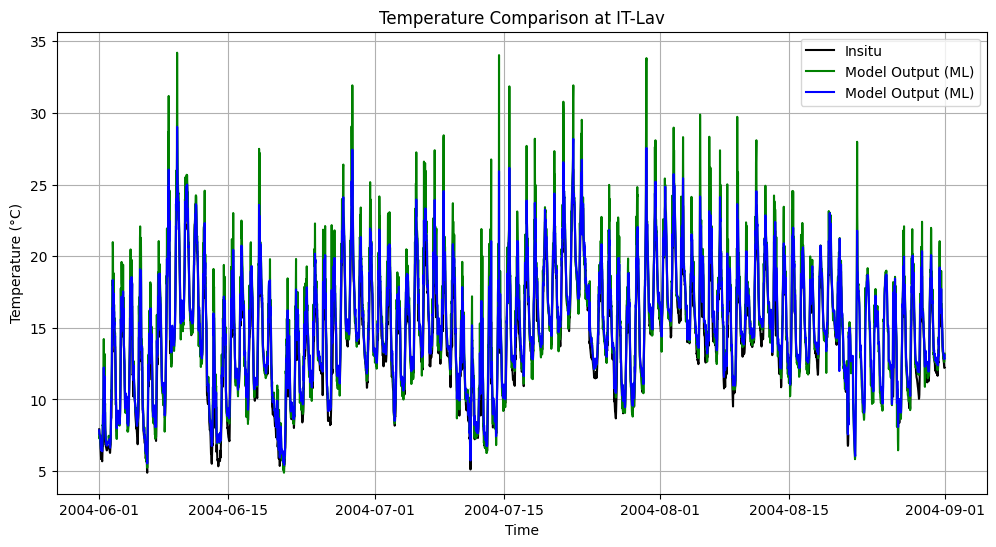

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='Insitu', color = 'black')
plt.plot(df_model_bigleaf.index, df_model_bigleaf['Tcave'], label='Model Output (ML)', color = 'green')
plt.plot(df_model_ML.index, df_model_ML['Tcave'], label='Model Output (ML)', color = 'blue')

plt.scatter(df_MODIS_LST_poi.index, df_MODIS_LST_poi['LST_Day_C'], label='MODIS LST', color='red', s=10)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Comparison at {station}')
plt.legend()
plt.grid()
plt.show()

In [33]:
df_combined_insitu = pd.DataFrame({
    'Insitu_LST': df_insitu_selected['LST'],
    'Model_ML_Tcave': df_model_ML['Tcave'],
    'Model_Bigleaf_Tcave': df_model_bigleaf['Tcave'],
})

In [29]:
# Filter df_MODIS_LST_poi to only include rows where 'closest_model_time' exists in df_model_output.index
df_matched = df_MODIS_LST_poi[df_MODIS_LST_poi['closest_model_time'].isin(df_model_ML.index)]

# Set 'closest_model_time' as the index to align with df_model_output
df_matched = df_matched.set_index('closest_model_time')

# Align both dataframes and create a new one
df_combined = pd.DataFrame({
    'Tcave_ML': df_model_ML.loc[df_matched.index, 'Tcave'],
    'Tcave_Bigleaf': df_model_bigleaf.loc[df_matched.index, 'Tcave'],
    'LST_Day_C': df_matched['LST_Day_C']
})


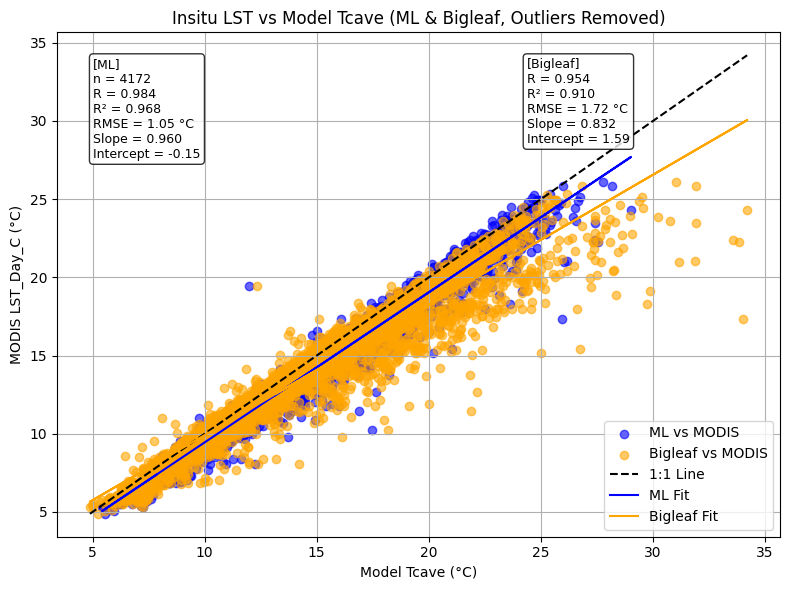

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress, pearsonr

# # Step 1: Drop NaNs
df_clean = df_combined_insitu.dropna(subset=['Model_ML_Tcave', 'Model_Bigleaf_Tcave', 'Insitu_LST'])

# # Step 2: Compute residuals for both models
# df_clean['residual_ML'] = df_clean['LST_Day_C'] - df_clean['Tcave_ML']
# df_clean['residual_Bigleaf'] = df_clean['LST_Day_C'] - df_clean['Tcave_Bigleaf']

# # Step 3: Filter outliers (e.g., z-score < 2 for both)
# z_ML = np.abs((df_clean['residual_ML'] - df_clean['residual_ML'].mean()) / df_clean['residual_ML'].std())
# z_BL = np.abs((df_clean['residual_Bigleaf'] - df_clean['residual_Bigleaf'].mean()) / df_clean['residual_Bigleaf'].std())
# df_filtered = df_clean[(z_ML < 2) & (z_BL < 2)]

# Extract variables
x_ml = df_clean['Model_ML_Tcave']
x_bl = df_clean['Model_Bigleaf_Tcave']
y = df_clean['Insitu_LST']

# Stats for ML
n_ml = len(x_ml)
R_ml, _ = pearsonr(x_ml, y)
R2_ml = R_ml**2
rmse_ml = np.sqrt(mean_squared_error(y, x_ml))
slope_ml, intercept_ml, *_ = linregress(x_ml, y)

# Stats for Bigleaf
R_bl, _ = pearsonr(x_bl, y)
R2_bl = R_bl**2
rmse_bl = np.sqrt(mean_squared_error(y, x_bl))
slope_bl, intercept_bl, *_ = linregress(x_bl, y)

# Stats text
stats_text_ml = (
    f"[ML]\n"
    f"n = {n_ml}\n"
    f"R = {R_ml:.3f}\n"
    f"R² = {R2_ml:.3f}\n"
    f"RMSE = {rmse_ml:.2f} °C\n"
    f"Slope = {slope_ml:.3f}\n"
    f"Intercept = {intercept_ml:.2f}"
)

stats_text_bl = (
    f"[Bigleaf]\n"
    f"R = {R_bl:.3f}\n"
    f"R² = {R2_bl:.3f}\n"
    f"RMSE = {rmse_bl:.2f} °C\n"
    f"Slope = {slope_bl:.3f}\n"
    f"Intercept = {intercept_bl:.2f}"
)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(x_ml, y, color='blue', alpha=0.6, label='ML vs MODIS')
plt.scatter(x_bl, y, color='orange', alpha=0.6, label='Bigleaf vs MODIS')

# 1:1 line
min_val = min(y.min(), x_ml.min(), x_bl.min())
max_val = max(y.max(), x_ml.max(), x_bl.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# Regression lines
plt.plot(x_ml, slope_ml * x_ml + intercept_ml, 'blue', label='ML Fit')
plt.plot(x_bl, slope_bl * x_bl + intercept_bl, 'orange', label='Bigleaf Fit')

# Labels and titles
plt.xlabel('Model Tcave (°C)')
plt.ylabel('MODIS LST_Day_C (°C)')
plt.title('Insitu LST vs Model Tcave (ML & Bigleaf, Outliers Removed)')
plt.legend()
plt.grid(True)

# Add text boxes
plt.gca().text(0.05, 0.95, stats_text_ml, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.gca().text(0.65, 0.95, stats_text_bl, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


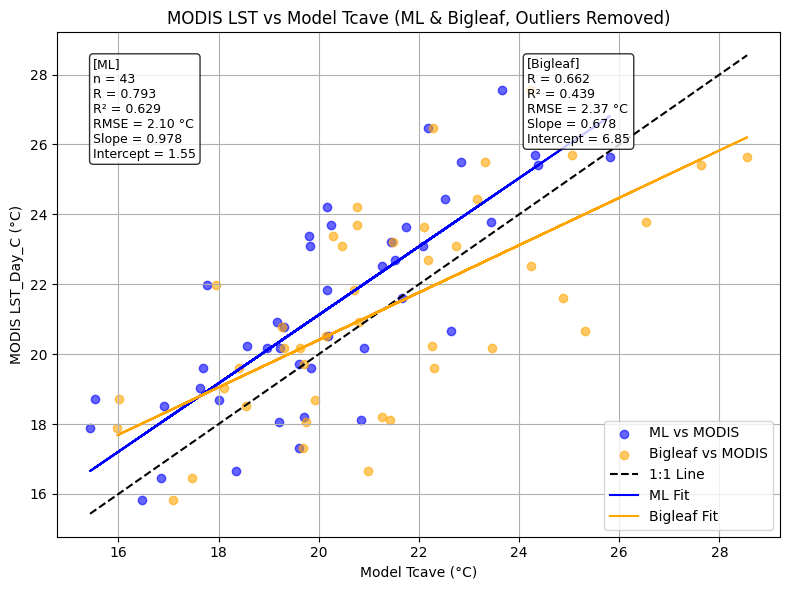

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress, pearsonr

# Step 1: Drop NaNs
df_clean = df_combined.dropna(subset=['Tcave_ML', 'Tcave_Bigleaf', 'LST_Day_C'])

# Step 2: Compute residuals for both models
df_clean['residual_ML'] = df_clean['LST_Day_C'] - df_clean['Tcave_ML']
df_clean['residual_Bigleaf'] = df_clean['LST_Day_C'] - df_clean['Tcave_Bigleaf']

# Step 3: Filter outliers (e.g., z-score < 2 for both)
z_ML = np.abs((df_clean['residual_ML'] - df_clean['residual_ML'].mean()) / df_clean['residual_ML'].std())
z_BL = np.abs((df_clean['residual_Bigleaf'] - df_clean['residual_Bigleaf'].mean()) / df_clean['residual_Bigleaf'].std())
df_filtered = df_clean[(z_ML < 2) & (z_BL < 2)]

# Extract variables
x_ml = df_filtered['Tcave_ML']
x_bl = df_filtered['Tcave_Bigleaf']
y = df_filtered['LST_Day_C']

# Stats for ML
n_ml = len(x_ml)
R_ml, _ = pearsonr(x_ml, y)
R2_ml = R_ml**2
rmse_ml = np.sqrt(mean_squared_error(y, x_ml))
slope_ml, intercept_ml, *_ = linregress(x_ml, y)

# Stats for Bigleaf
R_bl, _ = pearsonr(x_bl, y)
R2_bl = R_bl**2
rmse_bl = np.sqrt(mean_squared_error(y, x_bl))
slope_bl, intercept_bl, *_ = linregress(x_bl, y)

# Stats text
stats_text_ml = (
    f"[ML]\n"
    f"n = {n_ml}\n"
    f"R = {R_ml:.3f}\n"
    f"R² = {R2_ml:.3f}\n"
    f"RMSE = {rmse_ml:.2f} °C\n"
    f"Slope = {slope_ml:.3f}\n"
    f"Intercept = {intercept_ml:.2f}"
)

stats_text_bl = (
    f"[Bigleaf]\n"
    f"R = {R_bl:.3f}\n"
    f"R² = {R2_bl:.3f}\n"
    f"RMSE = {rmse_bl:.2f} °C\n"
    f"Slope = {slope_bl:.3f}\n"
    f"Intercept = {intercept_bl:.2f}"
)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(x_ml, y, color='blue', alpha=0.6, label='ML vs MODIS')
plt.scatter(x_bl, y, color='orange', alpha=0.6, label='Bigleaf vs MODIS')

# 1:1 line
min_val = min(y.min(), x_ml.min(), x_bl.min())
max_val = max(y.max(), x_ml.max(), x_bl.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 Line')

# Regression lines
plt.plot(x_ml, slope_ml * x_ml + intercept_ml, 'blue', label='ML Fit')
plt.plot(x_bl, slope_bl * x_bl + intercept_bl, 'orange', label='Bigleaf Fit')

# Labels and titles
plt.xlabel('Model Tcave (°C)')
plt.ylabel('MODIS LST_Day_C (°C)')
plt.title('MODIS LST vs Model Tcave (ML & Bigleaf, Outliers Removed)')
plt.legend()
plt.grid(True)

# Add text boxes
plt.gca().text(0.05, 0.95, stats_text_ml, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.gca().text(0.65, 0.95, stats_text_bl, transform=plt.gca().transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [ ]:
#Make everything numeric
df_model_anciliary_bigleaf = df_model_anciliary_bigleaf.apply(pd.to_numeric, errors='coerce')
df_model_anciliary_vMLWV = df_model_anciliary_vMLWV.apply(pd.to_numeric, errors='coerce')
df_model_fluxes_bigleaf = df_model_fluxes_bigleaf.apply(pd.to_numeric, errors='coerce')
df_model_fluxes_vMLWV = df_model_fluxes_vMLWV.apply(pd.to_numeric, errors='coerce')
# df_model_rac = df_model_rac.apply(pd.to_numeric, errors='coerce')
# df_model_rbl = df_model_rbl.apply(pd.to_numeric, errors='coerce')
# df_model_Tch = df_model_Tch.apply(pd.to_numeric, errors='coerce')
# df_model_Tcu = df_model_Tcu.apply(pd.to_numeric, errors='coerce')
# df_model_Hch = df_model_Hch.apply(pd.to_numeric, errors='coerce')
# df_model_Hcu = df_model_Hcu.apply(pd.to_numeric, errors='coerce')
# df_model_Rnch = df_model_Rnch.apply(pd.to_numeric, errors='coerce')
# df_model_Rncu = df_model_Rncu.apply(pd.to_numeric, errors='coerce')
# df_model_lEch = df_model_lEch.apply(pd.to_numeric, errors='coerce')
# df_model_lEcu = df_model_lEcu.apply(pd.to_numeric, errors='coerce')
# df_model_fraction  = df_model_fraction.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Add time column to the DataFrames and make it index 
df_model_anciliary_bigleaf['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_anciliary_vMLWV['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_fluxes_bigleaf['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())
df_model_fluxes_vMLWV['time'] = pd.to_datetime(ds_forcing_selected['time'].values.flatten())



In [ ]:
# Set time as index
df_model_anciliary_bigleaf.set_index('time', inplace=True)
df_model_anciliary_vMLWV.set_index('time', inplace=True)
df_model_fluxes_bigleaf.set_index('time', inplace=True)
df_model_fluxes_vMLWV.set_index('time', inplace=True)

In [ ]:
# GEt LST
# COmpute LST In degree C from LW_OUT
df_insitu_selected['LST'] = temperature_from_lw_out(
    df_insitu_selected['LW_OUT'].values,
    df_insitu_selected['LW_IN_F'].values,
    emissivity=0.98
) - 273.15

### Plotting Fluxes

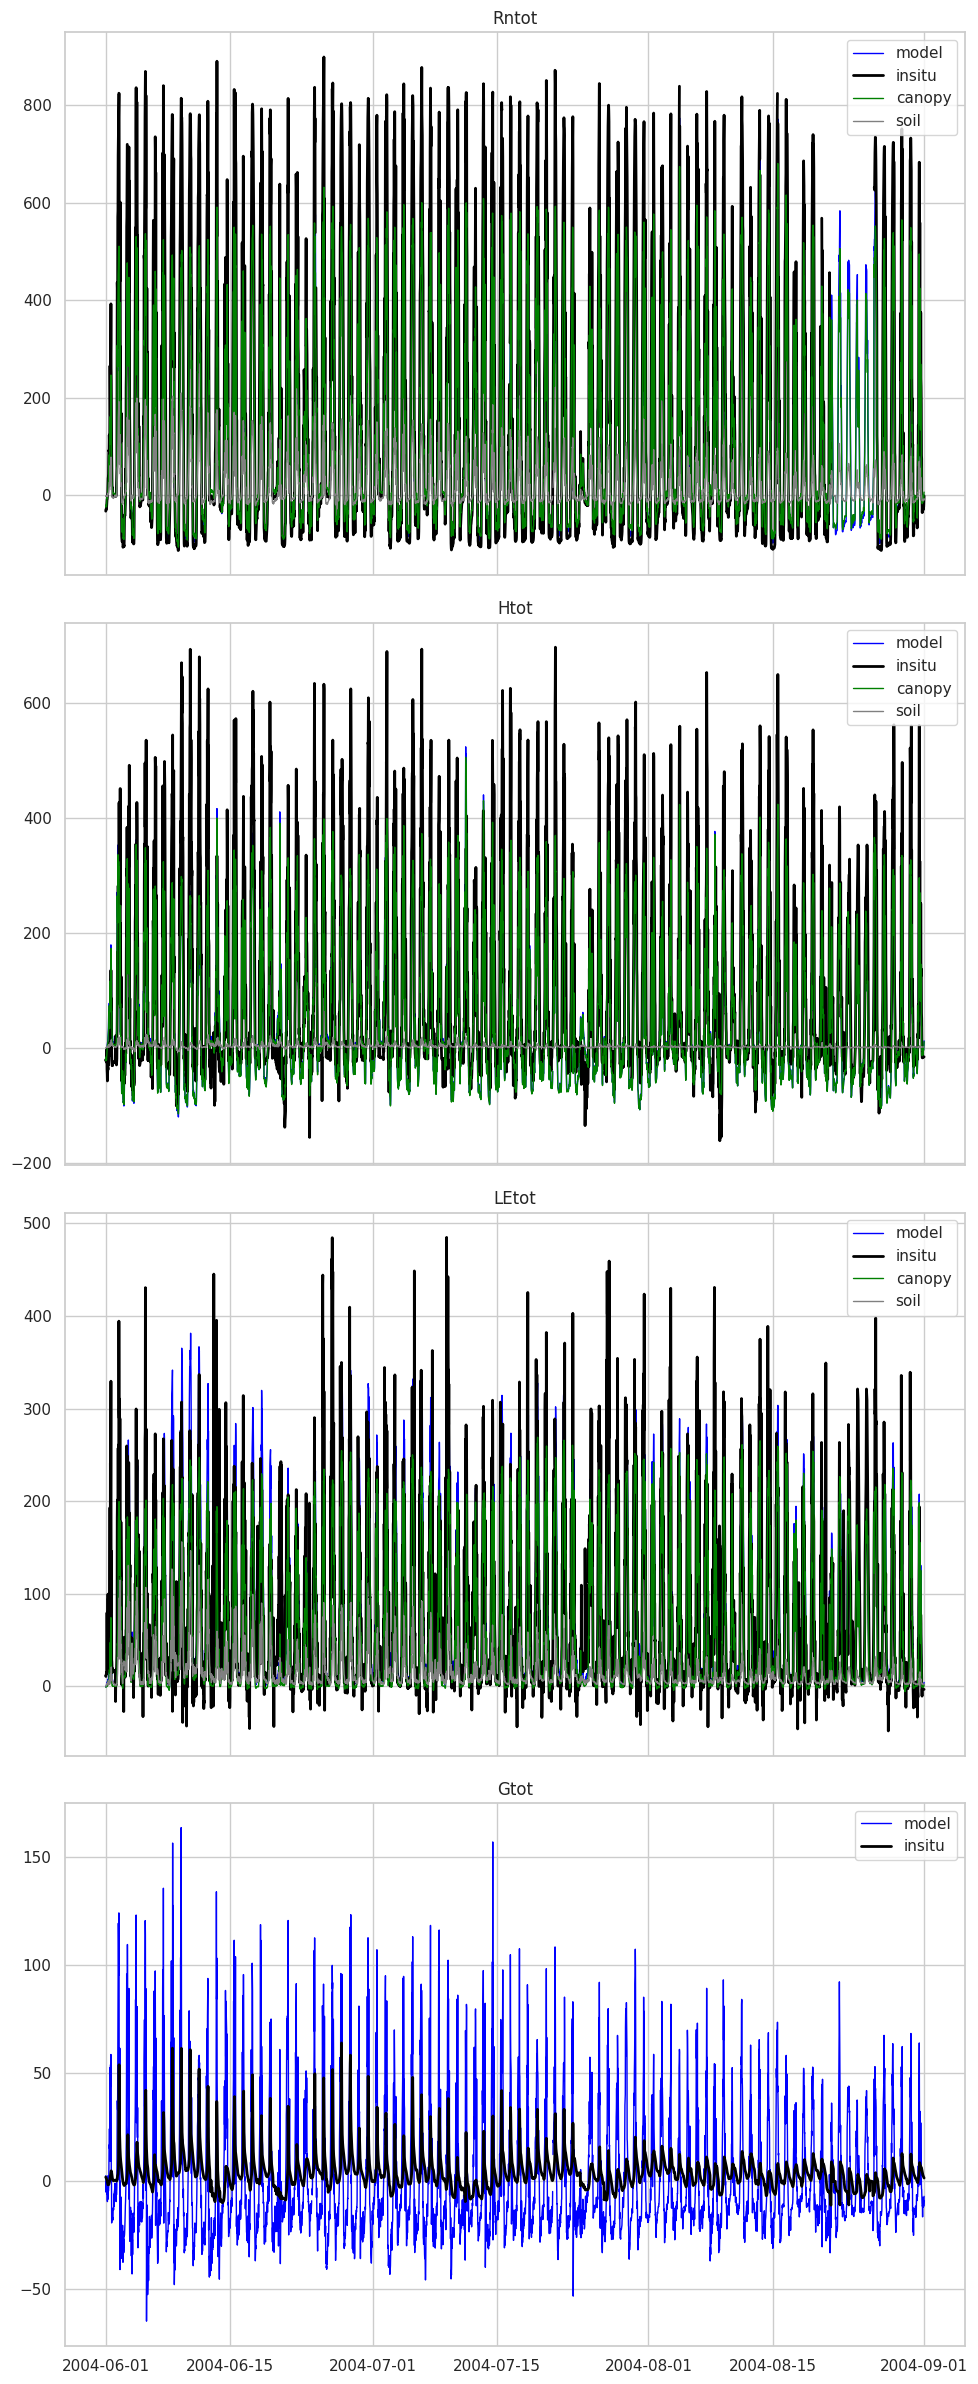

In [31]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(4, 1, figsize=(10, 24), sharex=True)

# Plot 1: Rntot
# axs[0].plot(df_fluxes_base_poi.index, df_fluxes_base_poi.Rntot, label='base', color='red', linewidth=1.5)
axs[0].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Rntot, label='model', color='blue', linewidth=1)
axs[0].plot(df_insitu_selected.index, df_insitu_selected.NETRAD, label='insitu', color='black', linewidth=2)
axs[0].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Rnctot, label='canopy', color='green', linewidth=1)
axs[0].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Rnstot, label='soil', color='grey', linewidth=1)
axs[0].set_title('Rntot')
axs[0].legend()

# Plot 2: Htot
axs[1].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Htot, label='model', color='blue', linewidth=1)
axs[1].plot(df_insitu_selected.index, df_insitu_selected.H_F_MDS, label='insitu', color='black', linewidth=2)
axs[1].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Hctot, label='canopy', color='green', linewidth=1)
axs[1].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Hstot, label='soil', color='grey', linewidth=1)
axs[1].set_title('Htot')
axs[1].legend()

# Plot 3: lEtot
axs[2].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.lEtot, label='model', color='blue', linewidth=1)
axs[2].plot(df_insitu_selected.index, df_insitu_selected.LE_F_MDS, label='insitu', color='black', linewidth=2)
axs[2].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.lEctot, label='canopy', color='green', linewidth=1)
axs[2].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.lEstot, label='soil', color='grey', linewidth=1)
axs[2].set_title('LEtot')
axs[2].legend()

# Plot 4: Gtot
axs[3].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Gtot, label='model', color='blue', linewidth=1)
axs[3].plot(df_insitu_selected.index, df_insitu_selected.G_F_MDS, label='insitu', color='black', linewidth=2)
axs[3].set_title('Gtot')
axs[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [57]:
# Define time range
start_date = "2004-07-01"
end_date = "2004-07-07"

# Subset data
df_model_bigleaf_fluxes = df_model_bigleaf_fluxes.loc[start_date:end_date]
df_model_ML_fluxes = df_model_ML_fluxes.loc[start_date:end_date]
df_insitu_selected = df_insitu_selected.loc[start_date:end_date]


In [52]:
df_insitu_selected['GPP_NT_VUT_REF'] = convert_umolCO2_to_kgC(df_insitu_selected['GPP_NT_VUT_REF'].values)
df_insitu_selected['NEE_VUT_REF'] = convert_umolCO2_to_kgC(df_insitu_selected['NEE_VUT_REF'].values)

/home/khanalp/tmp/ipykernel_2281506/1412834479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['GPP_NT_VUT_REF'] = convert_umolCO2_to_kgC(df_insitu_selected['GPP_NT_VUT_REF'].values)
/home/khanalp/tmp/ipykernel_2281506/1412834479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['NEE_VUT_REF'] = convert_umolCO2_to_kgC(df_insitu_selected['NEE_VUT_REF'].values)


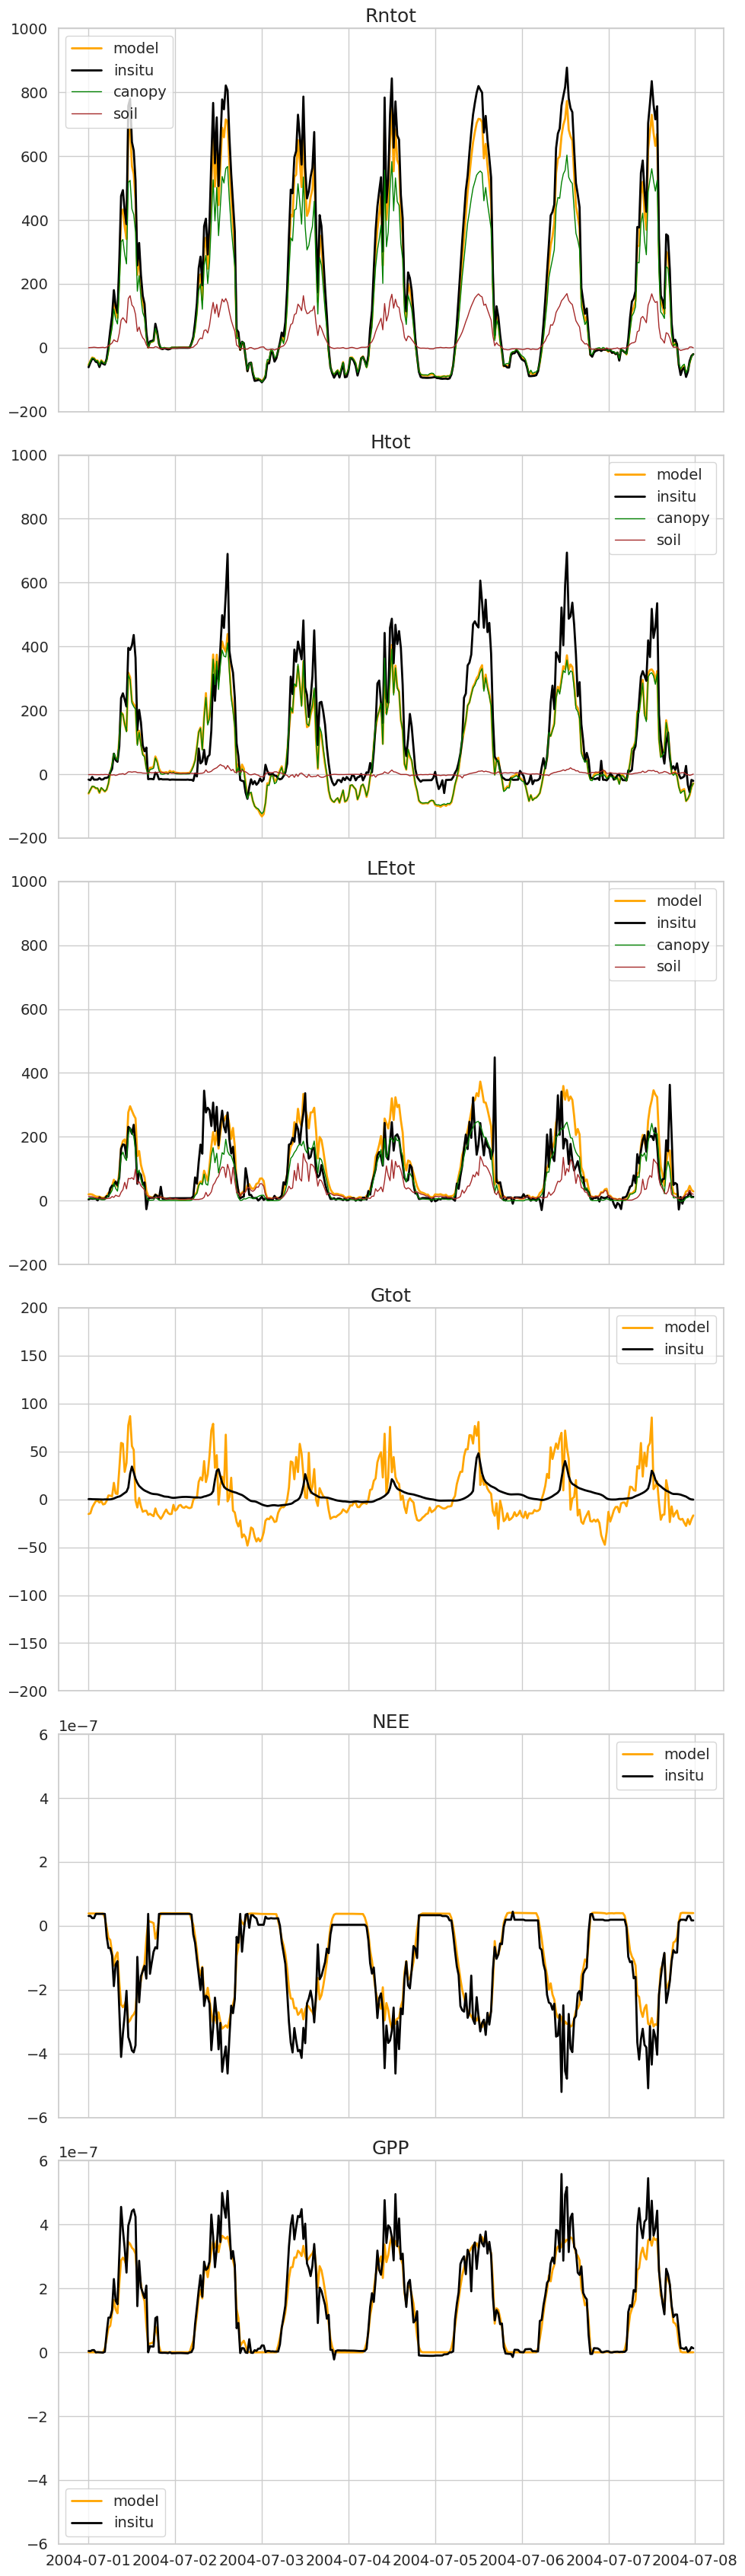

In [80]:


# --- Aesthetics ------------------------------------------------------------
sns.set_theme(
    style="whitegrid",
    rc={
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "figure.titlesize": 20,
    },
)

# --- Create figure and axes ------------------------------------------------
fig, axs = plt.subplots(6, 1, figsize=(10, 34), sharex=True)

# -------------------- 1. Rntot ---------------------------------------------
axs[0].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.Rntot,
            label="model",  color="orange",  lw=2)
axs[0].plot(df_insitu_selected.index, df_insitu_selected.NETRAD,
            label="insitu", color="black", lw=2)
axs[0].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.Rnctot,
            label="canopy", color="green", lw=1)
axs[0].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.Rnstot,
            label="soil",   color="brown",  lw=1)
axs[0].set_ylim(-200, 1000)
axs[0].set_title("Rntot"); axs[0].legend()

# -------------------- 2. Htot ----------------------------------------------
axs[1].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.Htot,
            label="model",  color="orange",  lw=2)
axs[1].plot(df_insitu_selected.index, df_insitu_selected.H_F_MDS,
            label="insitu", color="black", lw=2)
axs[1].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.Hctot,
            label="canopy", color="green", lw=1)
axs[1].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.Hstot,
            label="soil",   color="brown",  lw=1)
axs[1].set_ylim(-200, 1000)
axs[1].set_title("Htot"); axs[1].legend()

# -------------------- 3. LEtot ---------------------------------------------
axs[2].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.lEtot,
            label="model",  color="orange",  lw=2)
axs[2].plot(df_insitu_selected.index, df_insitu_selected.LE_F_MDS,
            label="insitu", color="black", lw=2)
axs[2].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.lEctot,
            label="canopy", color="green", lw=1)
axs[2].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.lEstot,
            label="soil",   color="brown",  lw=1)
axs[2].set_ylim(-200, 1000)
axs[2].set_title("LEtot"); axs[2].legend()

# -------------------- 4. Gtot ----------------------------------------------
axs[3].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.Gtot,
            label="model",  color="orange",  lw=2)
axs[3].plot(df_insitu_selected.index, df_insitu_selected.G_F_MDS,
            label="insitu", color="black", lw=2)
axs[3].set_ylim(-200, 200)
axs[3].set_title("Gtot"); axs[3].legend()

# -------------------- 5. NEE -----------------------------------------------
axs[4].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.NEE,
            label="model",  color="orange",  lw=2)
axs[4].plot(df_insitu_selected.index, df_insitu_selected.NEE_VUT_REF,
            label="insitu", color="black", lw=2)
axs[4].set_ylim(-6e-7, 6e-7)
axs[4].set_title("NEE"); axs[4].legend()

# -------------------- 6. GPP -----------------------------------------------
axs[5].plot(df_model_ML_fluxes.index, df_model_ML_fluxes.GPP,
            label="model",  color="orange",  lw=2)
axs[5].plot(df_insitu_selected.index, df_insitu_selected.GPP_NT_VUT_REF,
            label="insitu", color="black", lw=2)
axs[5].set_ylim(-6e-7, 6e-7)
axs[5].set_title("GPP"); axs[5].legend()

# --- Final touches ---------------------------------------------------------
plt.tight_layout()
plt.show()


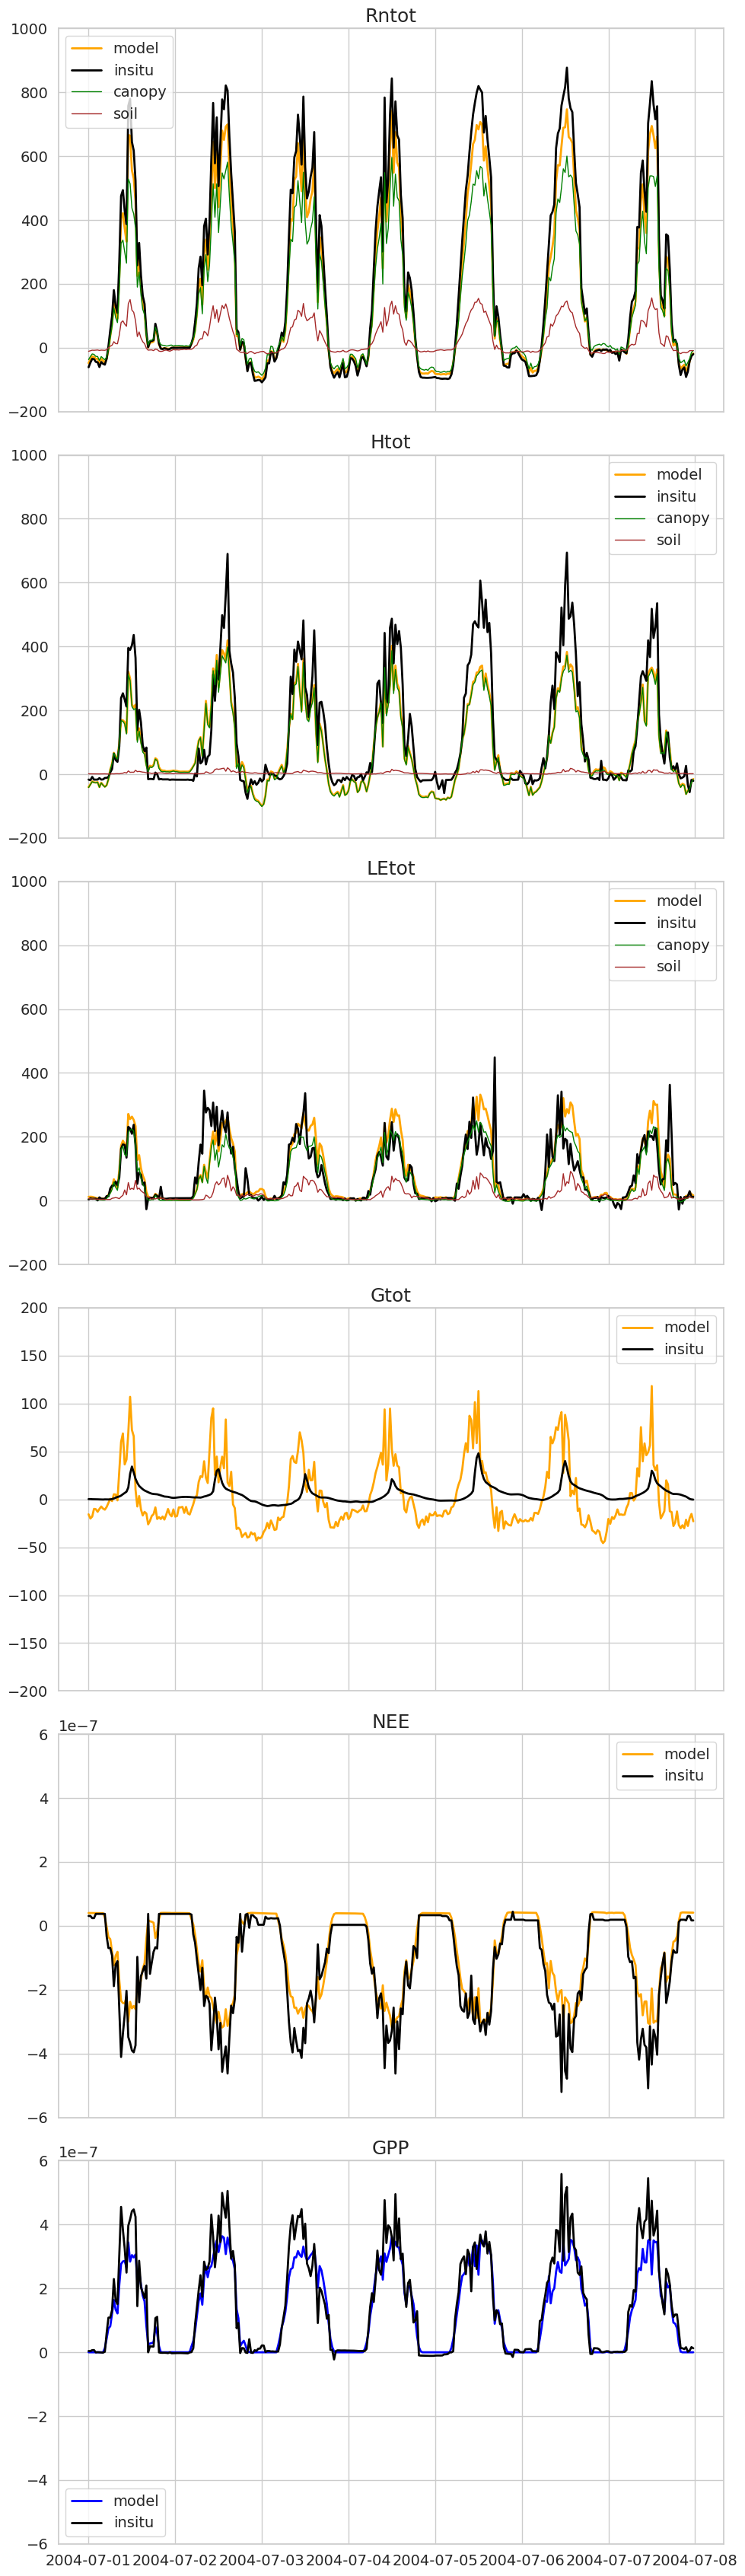

In [82]:
# --- Aesthetics ------------------------------------------------------------
sns.set_theme(
    style="whitegrid",
    rc={
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "figure.titlesize": 20,
    },
)

# --- Create figure and axes ------------------------------------------------
fig, axs = plt.subplots(6, 1, figsize=(10, 34), sharex=True)

# -------------------- 1. Rntot ---------------------------------------------
axs[0].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Rntot,
            label="model",  color="orange",  lw=2)
axs[0].plot(df_insitu_selected.index, df_insitu_selected.NETRAD,
            label="insitu", color="black", lw=2)
axs[0].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Rnctot,
            label="canopy", color="green", lw=1)
axs[0].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Rnstot,
            label="soil",   color="brown",  lw=1)
axs[0].set_title("Rntot")
axs[0].set_ylim(-200, 1000)
axs[0].legend()

# -------------------- 2. Htot ----------------------------------------------
axs[1].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Htot,
            label="model",  color="orange",  lw=2)
axs[1].plot(df_insitu_selected.index, df_insitu_selected.H_F_MDS,
            label="insitu", color="black", lw=2)
axs[1].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Hctot,
            label="canopy", color="green", lw=1)
axs[1].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Hstot,
            label="soil",   color="brown",  lw=1)
axs[1].set_title("Htot")
axs[1].set_ylim(-200, 1000)
axs[1].legend()

# -------------------- 3. LEtot ---------------------------------------------
axs[2].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.lEtot,
            label="model",  color="orange",  lw=2)
axs[2].plot(df_insitu_selected.index, df_insitu_selected.LE_F_MDS,
            label="insitu", color="black", lw=2)
axs[2].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.lEctot,
            label="canopy", color="green", lw=1)
axs[2].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.lEstot,
            label="soil",   color="brown",  lw=1)
axs[2].set_title("LEtot")
axs[2].set_ylim(-200, 1000)
axs[2].legend()

# -------------------- 4. Gtot ----------------------------------------------
axs[3].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.Gtot,
            label="model",  color="orange",  lw=2)
axs[3].plot(df_insitu_selected.index, df_insitu_selected.G_F_MDS,
            label="insitu", color="black", lw=2)
axs[3].set_title("Gtot")
axs[3].set_ylim(-200, 200)
axs[3].legend()

# -------------------- 5. NEE -----------------------------------------------
axs[4].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.NEE,
            label="model",  color="orange",  lw=2)
axs[4].plot(df_insitu_selected.index, df_insitu_selected.NEE_VUT_REF,
            label="insitu", color="black", lw=2)
axs[4].set_title("NEE")
axs[4].set_ylim(-6e-7, 6e-7)  # NEE typically ranges positive/negative
axs[4].legend()

# -------------------- 6. GPP -----------------------------------------------
axs[5].plot(df_model_bigleaf_fluxes.index, df_model_bigleaf_fluxes.GPP,
            label="model",  color="blue",  lw=2)
axs[5].plot(df_insitu_selected.index, df_insitu_selected.GPP_NT_VUT_REF,
            label="insitu", color="black", lw=2)
axs[5].set_title("GPP")
axs[5].set_ylim(-6e-7, 6e-7)
axs[5].legend()

# --- Final touches ---------------------------------------------------------
plt.tight_layout()
plt.show()


In [40]:
df_insitu_selected.columns

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F_MDS', 'TA_F_MDS_QC', 'TA_ERA',
       'TA_F', 'TA_F_QC', 'SW_IN_POT', 'SW_IN_F_MDS', 'SW_IN_F_MDS_QC',
       ...
       'GPP_DT_CUT_16', 'GPP_DT_CUT_25', 'GPP_DT_CUT_50', 'GPP_DT_CUT_75',
       'GPP_DT_CUT_84', 'GPP_DT_CUT_95', 'RECO_SR', 'RECO_SR_N', 'LST',
       'hour'],
      dtype='object', length=241)

/home/khanalp/tmp/ipykernel_2281506/2630971471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['hour'] = df_insitu_selected.index.hour


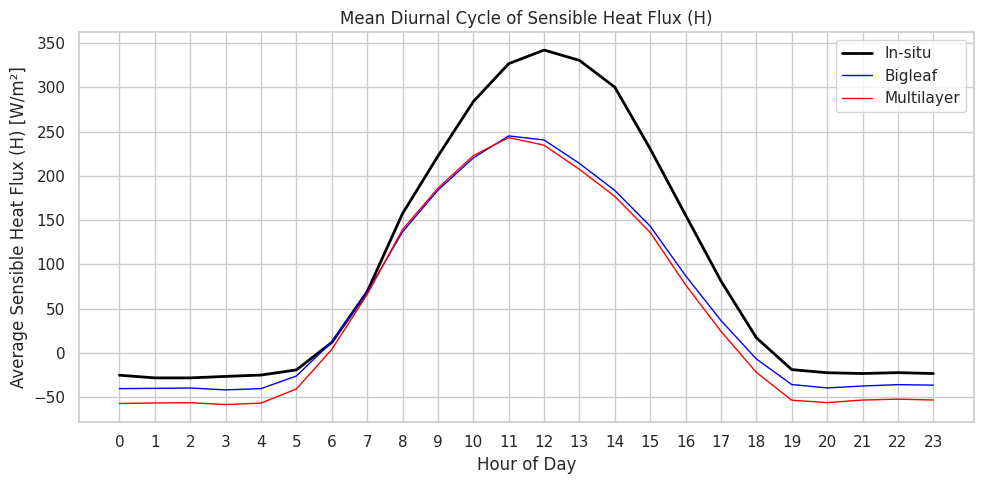

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create 'hour' column if not already present
df_insitu_selected['hour'] = df_insitu_selected.index.hour
df_model_bigleaf_fluxes['hour'] = df_model_bigleaf_fluxes.index.hour
df_model_ML_fluxes['hour'] = df_model_ML_fluxes.index.hour

# Step 2: Compute mean diurnal cycle
diurnal_insitu = df_insitu_selected.groupby('hour')['H_F_MDS'].mean()
diurnal_bigleaf = df_model_bigleaf_fluxes.groupby('hour')['Htot'].mean()
diurnal_ML = df_model_ML_fluxes.groupby('hour')['Htot'].mean()

# Step 3: Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(diurnal_insitu.index, diurnal_insitu.values, label='In-situ', color='black', linewidth=2)
plt.plot(diurnal_bigleaf.index, diurnal_bigleaf.values, label='Bigleaf', color='blue', linewidth=1)
plt.plot(diurnal_ML.index, diurnal_ML.values, label='Multilayer', color='red', linewidth=1)

plt.xlabel('Hour of Day')
plt.ylabel('Average Sensible Heat Flux (H) [W/m²]')
plt.title('Mean Diurnal Cycle of Sensible Heat Flux (H)')
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()


/home/khanalp/tmp/ipykernel_2281506/2949615364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected['hour'] = df_insitu_selected.index.hour


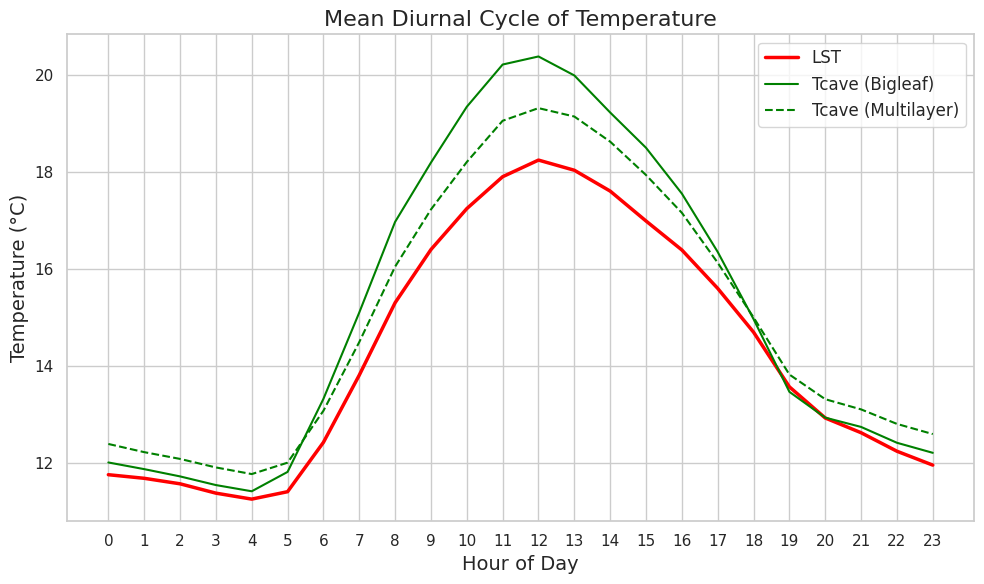

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Add 'hour' column
df_insitu_selected['hour'] = df_insitu_selected.index.hour
df_model_bigleaf['hour'] = df_model_bigleaf.index.hour
df_model_ML['hour'] = df_model_ML.index.hour

# Step 2: Compute diurnal means
diurnal_lst = df_insitu_selected.groupby('hour')['LST'].mean()
# diurnal_tair = df_insitu_selected.groupby('hour')['TA_F_MDS'].mean()
# diurnal_tsh = df_model_ancilliary.groupby('hour')['Tsh'].mean()
# diurnal_tsu = df_model_ancilliary.groupby('hour')['Tsu'].mean()
diurnal_tcave_bigleaf = df_model_bigleaf.groupby('hour')['Tcave'].mean()
diurnal_tcave_ml = df_model_ML.groupby('hour')['Tcave'].mean()

# Step 3: Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(diurnal_lst.index, diurnal_lst.values, label='LST', color='red', linewidth=2.5)
# plt.plot(diurnal_tair.index, diurnal_tair.values, label='Tair', color='black', linewidth=2.5)
# plt.plot(diurnal_tsh.index, diurnal_tsh.values, label='Tsh (soil)', color='blue', linewidth=1)
# plt.plot(diurnal_tsu.index, diurnal_tsu.values, label='Tsu (soil)', color='orange', linewidth=1)
plt.plot(diurnal_tcave_bigleaf.index, diurnal_tcave_bigleaf.values, label='Tcave (Bigleaf)', color='green', linewidth=1.5, linestyle='-')
plt.plot(diurnal_tcave_ml.index, diurnal_tcave_ml.values, label='Tcave (Multilayer)', color='green', linewidth=1.5, linestyle='--')

# Add labels and legend
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Mean Diurnal Cycle of Temperature', fontsize=16)
plt.xticks(range(0, 24))
plt.legend(fontsize=12)
plt.grid(True)

# Final layout
plt.tight_layout()
plt.show()


NameError: name 'df_model_anciliary_bigleaf' is not defined

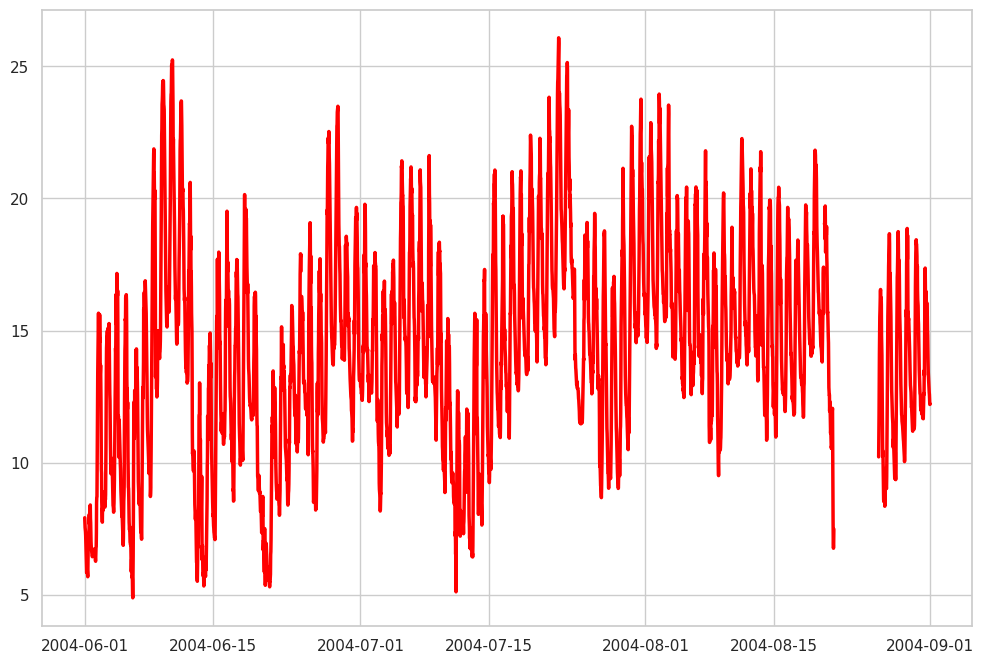

In [37]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable
plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='LST ', color='red', linewidth=2.5)
# plt.plot(df_insitu_selected.index, df_insitu_selected['TA_F_MDS'], label='Tair ', color='black', linewidth=2.5)
# plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsh'], label='Tsh (soil) ', color='blue', linewidth=1)
# plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsu'], label='Tsu (soil) ', color='orange', linewidth=1)
plt.plot(df_model_anciliary_bigleaf.index, df_model_anciliary_bigleaf['Tcave'], label='Tcave ', color='green', linewidth=1)
plt.plot(df_model_anciliary_vMLWV.index, df_model_anciliary_vMLWV['Tcave'], label='Tcave ', color='green', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Temperature Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Rnssu, label='Rnssu', color='red', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Hssu, label='Hssu', color='green', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.lEssu, label='lEssu', color='blue', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Gssu, label='Gssu', color='grey', linewidth=1.5)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Energy balance component sunlit part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Rnssh, label='Rnssh', color='red', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Hssh, label='Hssh', color='green', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.lEssh, label='lEssh', color='blue', linewidth=1.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Gssh, label='Gssh', color='grey', linewidth=1.5)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Energy balance component shaded part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable
plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='LST ', color='red', linewidth=2.5)
# plt.plot(df_insitu_selected.index, df_insitu_selected['TA_F_MDS'], label='Tair ', color='black', linewidth=2.5)
# plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsh'], label='Tsh (soil) ', color='blue', linewidth=1)
# plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsu'], label='Tsu (soil) ', color='orange', linewidth=1)
plt.plot(df_model_anciliary_bigleaf.index, df_model_anciliary_bigleaf['Tcave'], label='Tcave ', color='green', linewidth=1)
plt.plot(df_model_anciliary_vMLWV.index, df_model_anciliary_vMLWV['Tcave'], label='Tcave ', color='green', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Temperature Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.Fsh, label='Fraction', color='red', linewidth=1.5)


# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Fraction of shaded part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable with labels and colors
plt.plot(df_model_ancilliary.index, df_model_ancilliary.LAI, label='Fraction', color='red', linewidth=1.5)


# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Fraction of shaded part', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable
plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='LST ', color='red', linewidth=2.5)
plt.plot(df_insitu_selected.index, df_insitu_selected['TA_F_MDS'], label='Tair ', color='black', linewidth=2.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsh'], label='Tsh (soil) ', color='blue', linewidth=1)
plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsu'], label='Tsu (soil) ', color='orange', linewidth=1)
plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tcave'], label='Tcave ', color='green', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Temperature Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
h = np.linspace(df_model_ancilliary.h[0],0, 30)
date_str = "2004-07-01"
time_steps = pd.date_range(start=f"{date_str} 00:00", end=f"{date_str} 21:00", freq="3H")


In [ ]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.flatten()

for i, selected_time in enumerate(time_steps):
    selected_idx = df_model_ancilliary.index.get_loc(selected_time)

    ax = axes[i]
    ax.plot(df_model_rac.iloc[:, selected_idx], h, color='blue', label='rac')
    ax.plot(df_model_rbl.iloc[:, selected_idx], h, color='red', label='rbl')
    ax.plot(df_model_rbl.iloc[:, selected_idx] + df_model_rac.iloc[:, selected_idx], h, color='green', label='total')

    ax.set_title(selected_time.strftime("%H:%M"), fontsize=10)
    ax.grid(True)
    if i % 4 == 0:
        ax.set_ylabel("Height (m)")
    if i >= 4:
        ax.set_xlabel("Resistance (s/m)")

# Legend only once
    ax.legend(loc='upper right', fontsize=9)

# Style
fig.suptitle("Aerodynamic Resistance Profiles on 2004-07-01", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.flatten()

for i, selected_time in enumerate(time_steps):
    selected_idx = df_model_ancilliary.index.get_loc(selected_time)

    ax = axes[i]
    ax.plot(df_model_Hcu.iloc[:, selected_idx], h, color='red', label='sunlit')
    ax.plot(df_model_Hch.iloc[:, selected_idx], h, color='blue', label='shaded')
    # ax.plot(df_model_rbl.iloc[:, selected_idx] + df_model_rac.iloc[:, selected_idx], h, color='green', label='total')

    ax.set_title(selected_time.strftime("%H:%M"), fontsize=10)
    ax.grid(True)
    if i % 4 == 0:
        ax.set_ylabel("Height (m)")
    if i >= 4:
        ax.set_xlabel("Sensible Heat Flux (W/m²)")

# Legend only once
    ax.legend(loc='upper right', fontsize=9)

# Style
fig.suptitle("Sensible Heat Flux on 2004-07-01", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.flatten()

for i, selected_time in enumerate(time_steps):
    selected_idx = df_model_ancilliary.index.get_loc(selected_time)

    ax = axes[i]
    ax.plot(df_model_Rncu.iloc[:, selected_idx], h, color='red', label='sunlit')
    ax.plot(df_model_Rnch.iloc[:, selected_idx], h, color='blue', label='shaded')
    # ax.plot(df_model_rbl.iloc[:, selected_idx] + df_model_rac.iloc[:, selected_idx], h, color='green', label='total')

    ax.set_title(selected_time.strftime("%H:%M"), fontsize=10)
    ax.grid(True)
    if i % 4 == 0:
        ax.set_ylabel("Height (m)")
    if i >= 4:
        ax.set_xlabel("Net radiation (W/m²)")

# Legend only once
    ax.legend(loc='upper right', fontsize=9)

# Style
fig.suptitle("Net radiation on 2004-07-01", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.flatten()

for i, selected_time in enumerate(time_steps):
    selected_idx = df_model_ancilliary.index.get_loc(selected_time)

    ax = axes[i]
    ax.plot(df_model_lEcu.iloc[:, selected_idx], h, color='red', label='sunlit')
    ax.plot(df_model_lEch.iloc[:, selected_idx], h, color='blue', label='shaded')
    # ax.plot(df_model_rbl.iloc[:, selected_idx] + df_model_rac.iloc[:, selected_idx], h, color='green', label='total')

    ax.set_title(selected_time.strftime("%H:%M"), fontsize=10)
    ax.grid(True)
    if i % 4 == 0:
        ax.set_ylabel("Height (m)")
    if i >= 4:
        ax.set_xlabel("Latent Heat Flux (W/m²)")

# Legend only once
    ax.legend(loc='upper right', fontsize=9)

# Style
fig.suptitle("Latent Heat Flux on 2004-07-01", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.flatten()

for i, selected_time in enumerate(time_steps):
    selected_idx = df_model_ancilliary.index.get_loc(selected_time)

    ax = axes[i]
    ax.plot(df_model_Tcu.iloc[:, selected_idx], h, color='red', label='sunlit')
    ax.plot(df_model_Tch.iloc[:, selected_idx], h, color='blue', label='shaded')
    # ax.plot(df_model_rbl.iloc[:, selected_idx] + df_model_rac.iloc[:, selected_idx], h, color='green', label='total')

    ax.set_title(selected_time.strftime("%H:%M"), fontsize=10)
    ax.grid(True)
    if i % 4 == 0:
        ax.set_ylabel("Height (m)")
    if i >= 4:
        ax.set_xlabel("Canopy Temperature (°C)")

# Legend only once
    ax.legend(loc='upper right', fontsize=9)

# Style
fig.suptitle("Canopy temperature on 2004-07-01", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()

In [ ]:
df_model_rbcsh = pd.read_csv(os.path.join(model_output, station, "vMay28v0", "rbcsh.csv"),header=None)
df_model_rac = pd.read_csv(os.path.join(model_output, station, "vMay28v0", "rac.csv"),header=None)

In [ ]:
df_model_rac

In [ ]:
df_model_rbcsh.iloc[0,:].plot(color = 'red', label='rbcsh')
df_model_rac.iloc[0,:].plot(color = 'blue', label='rac')
plt.legend()

In [ ]:
df_model_rbcsh.iloc[29,:].plot(color = 'red', label='rbcsh')
df_model_rac.iloc[29,:].plot(color = 'blue', label='rac')
plt.legend()

In [ ]:
# Set publication-style aesthetics
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot each variable
plt.plot(df_insitu_selected.index, df_insitu_selected['LST'], label='LST ', color='red', linewidth=2.5)
plt.plot(df_insitu_selected.index, df_insitu_selected['TA_F_MDS'], label='Tair ', color='black', linewidth=2.5)
plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsh'], label='Tsh (soil) ', color='blue', linewidth=1)
plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tsu'], label='Tsu (soil) ', color='orange', linewidth=1)
plt.plot(df_model_ancilliary.index, df_model_ancilliary['Tcave'], label='Tcave ', color='green', linewidth=1)

# Add labels, legend, and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Temperature Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
ds_forcing.canopy_height.values